<a href="https://colab.research.google.com/github/Abbhiraami/ML_AI_masters/blob/main/RNN_Assignment%20/RNN_Assg_Stock_Price_Prediction_Abbhiraami_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')\

### Packages for combinators
import itertools

## Display python tables
from IPython.display import display

### Sklearn essentials

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### statsmodel
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


### Tensorflow essentials

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, Dropout, LSTM, GRU,Activation

### Optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping

### Extracting files from google drive
from google.colab import drive
from os import listdir




### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [3]:
# Define a function to load data and aggregate them
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip "/content/drive/MyDrive/RNN_Stock_Starter_Dataset.zip" -d "/content/RNN_data"

Archive:  /content/drive/MyDrive/RNN_Stock_Starter_Dataset.zip
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/AMZN_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/MSFT_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/GOOGL_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Assg_Stock_Price_Prediction_Starter.ipynb  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/IBM_stocks_data.csv  


In [8]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
root_dir="/content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data"
def read_data(root_dir):
  """
  Input: Mounted root directory
  Functionality: Extacts all the files and concatenates
  Output: Concatenated data
  """
  filnames=listdir(root_dir)
  df_all_comps=pd.DataFrame()
  for fil in  filnames:
    df=pd.read_csv(f"{root_dir}/{fil}")
    df_all_comps=pd.concat([df_all_comps,df])
  return df_all_comps

#### Data-Extracted
df_stocks_all=read_data(root_dir).reset_index()
df_stocks_all.drop_duplicates(inplace=True)
print(f"Shape of the data:{df_stocks_all.shape}")
df_stocks_all.head()


Shape of the data:(12077, 8)


,index,Date,Open,High,Low,Close,Volume,Name
0,0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [9]:
# View specifics of the data
df_stocks_all['Date']=pd.to_datetime(df_stocks_all['Date'])
df_stocks_all.groupby("Name").describe()


index                                                            Date  \
        count    mean  min     25%     50%      75%     max         std count   
Name                                                                            
AMZN   3019.0  1509.0  0.0  754.50  1509.0  2263.50  3018.0  871.654557  3019   
GOOGL  3019.0  1509.0  0.0  754.50  1509.0  2263.50  3018.0  871.654557  3019   
IBM    3020.0  1509.5  0.0  754.75  1509.5  2264.25  3019.0  871.943232  3020   
MSFT   3019.0  1509.0  0.0  754.50  1509.0  2263.50  3018.0  871.654557  3019   

                                      ...    Close              Volume  \
                                mean  ...      max         std   count   
Name                                  ...                                
AMZN   2012-01-01 20:00:33.388539392  ...  1195.83  279.980161  3019.0   
GOOGL  2012-01-01 20:00:33.388539392  ...  1085.09  236.343238  3019.0   
IBM    2012-01-01 14:54:59.602649088  ...   215.80   37.529387  3020.0   
MSFT   2012-01-01 20:00:33.388539392  ...    86.85   14.694656  3019.0   

                                                                     \
               mean        min          25%         50%         75%   
Name                                                                  
AMZN   5.931712e+06   986435.0   3137037.00   4724100.0   7135245.5   
GOOGL  3.551504e+06   521141.0   1760854.00   2517630.0   4242182.5   
IBM    5.773301e+06   254256.0   3622681.25   4928851.5   6965014.0   
MSFT   5.161762e+07  7425603.0  31365567.00  46175294.0  63222914.5   

                                  
               max           std  
Name                              
AMZN   104404589.0  5.122034e+06  
GOOGL   41182889.0  3.038599e+06  
IBM     30774276.0  3.192831e+06  
MSFT   591078581.0  3.114958e+07  

[4 rows x 56 columns]

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [10]:
# Handle Missing Values

# a. Missing values
print(f"Missing Values: \n {df_stocks_all.isnull().sum()}")

# b. Filtering only the missing data
print(f"The following companies has missing columns amd should be handled given the fact that is a time series data \n")
display(df_stocks_all[df_stocks_all.isnull().any(axis=1)])
miss_indx=df_stocks_all[df_stocks_all.isnull().any(axis=1)].index.values[0]
print(f"missing index:{miss_indx}")

### Missing Data handler - Filling with median of the specific company
df_stocks_all['Low']=df_stocks_all['Low'].fillna(df_stocks_all.loc[df_stocks_all['Name']=="IBM"]['Low'].median())
df_stocks_all['Open']=df_stocks_all['Open'].fillna(df_stocks_all.loc[df_stocks_all['Name']=="IBM"]['Open'].median()
)
print(f"Missed Values post fill: \n {df_stocks_all.isnull().sum()}\n")
print("FIlled rows:")
df_stocks_all.iloc[miss_indx,:]



Missing Values: 
 index     0
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
The following companies has missing columns amd should be handled given the fact that is a time series data 



,index,Date,Open,High,Low,Close,Volume,Name
11970,2913,2017-07-31,NaN,144.93,NaN,144.67,4355718,IBM


missing index:11970
Missed Values post fill: 
 index     0
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

FIlled rows:


,11970
index,2913
Date,2017-07-31 00:00:00
Open,149.61
High,144.93
Low,148.47
Close,144.67
Volume,4355718
Name,IBM


In [11]:
df_stocks_all.query("Date=='2017-07-31'")

,index,Date,Open,High,Low,Close,Volume,Name
2912,2912,2017-07-31,960.00,961.19,941.72,945.50,2293389,GOOGL
5931,2912,2017-07-31,73.30,73.44,72.41,72.70,23600054,MSFT
8950,2912,2017-07-31,1019.05,1019.05,987.02,987.78,7352063,AMZN
11970,2913,2017-07-31,149.61,144.93,148.47,144.67,4355718,IBM


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

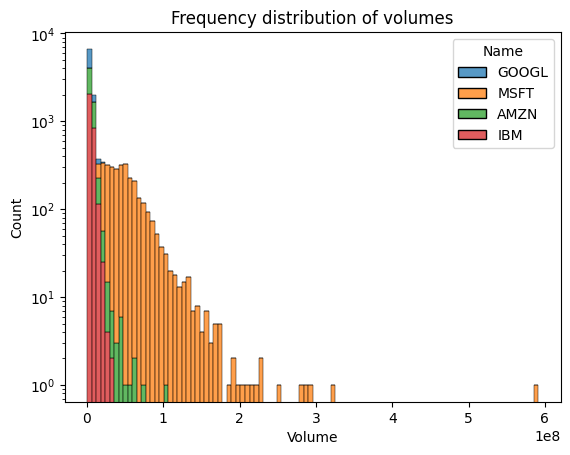

In [12]:
# Frequency distribution of volumes
## adjust bin size of histogram
sns.histplot(data=df_stocks_all,x="Volume",bins=100,hue="Name",multiple="stack")
plt.title("Frequency distribution of volumes")
plt.yscale('log')
# plt.xscale('log')
plt.show( )

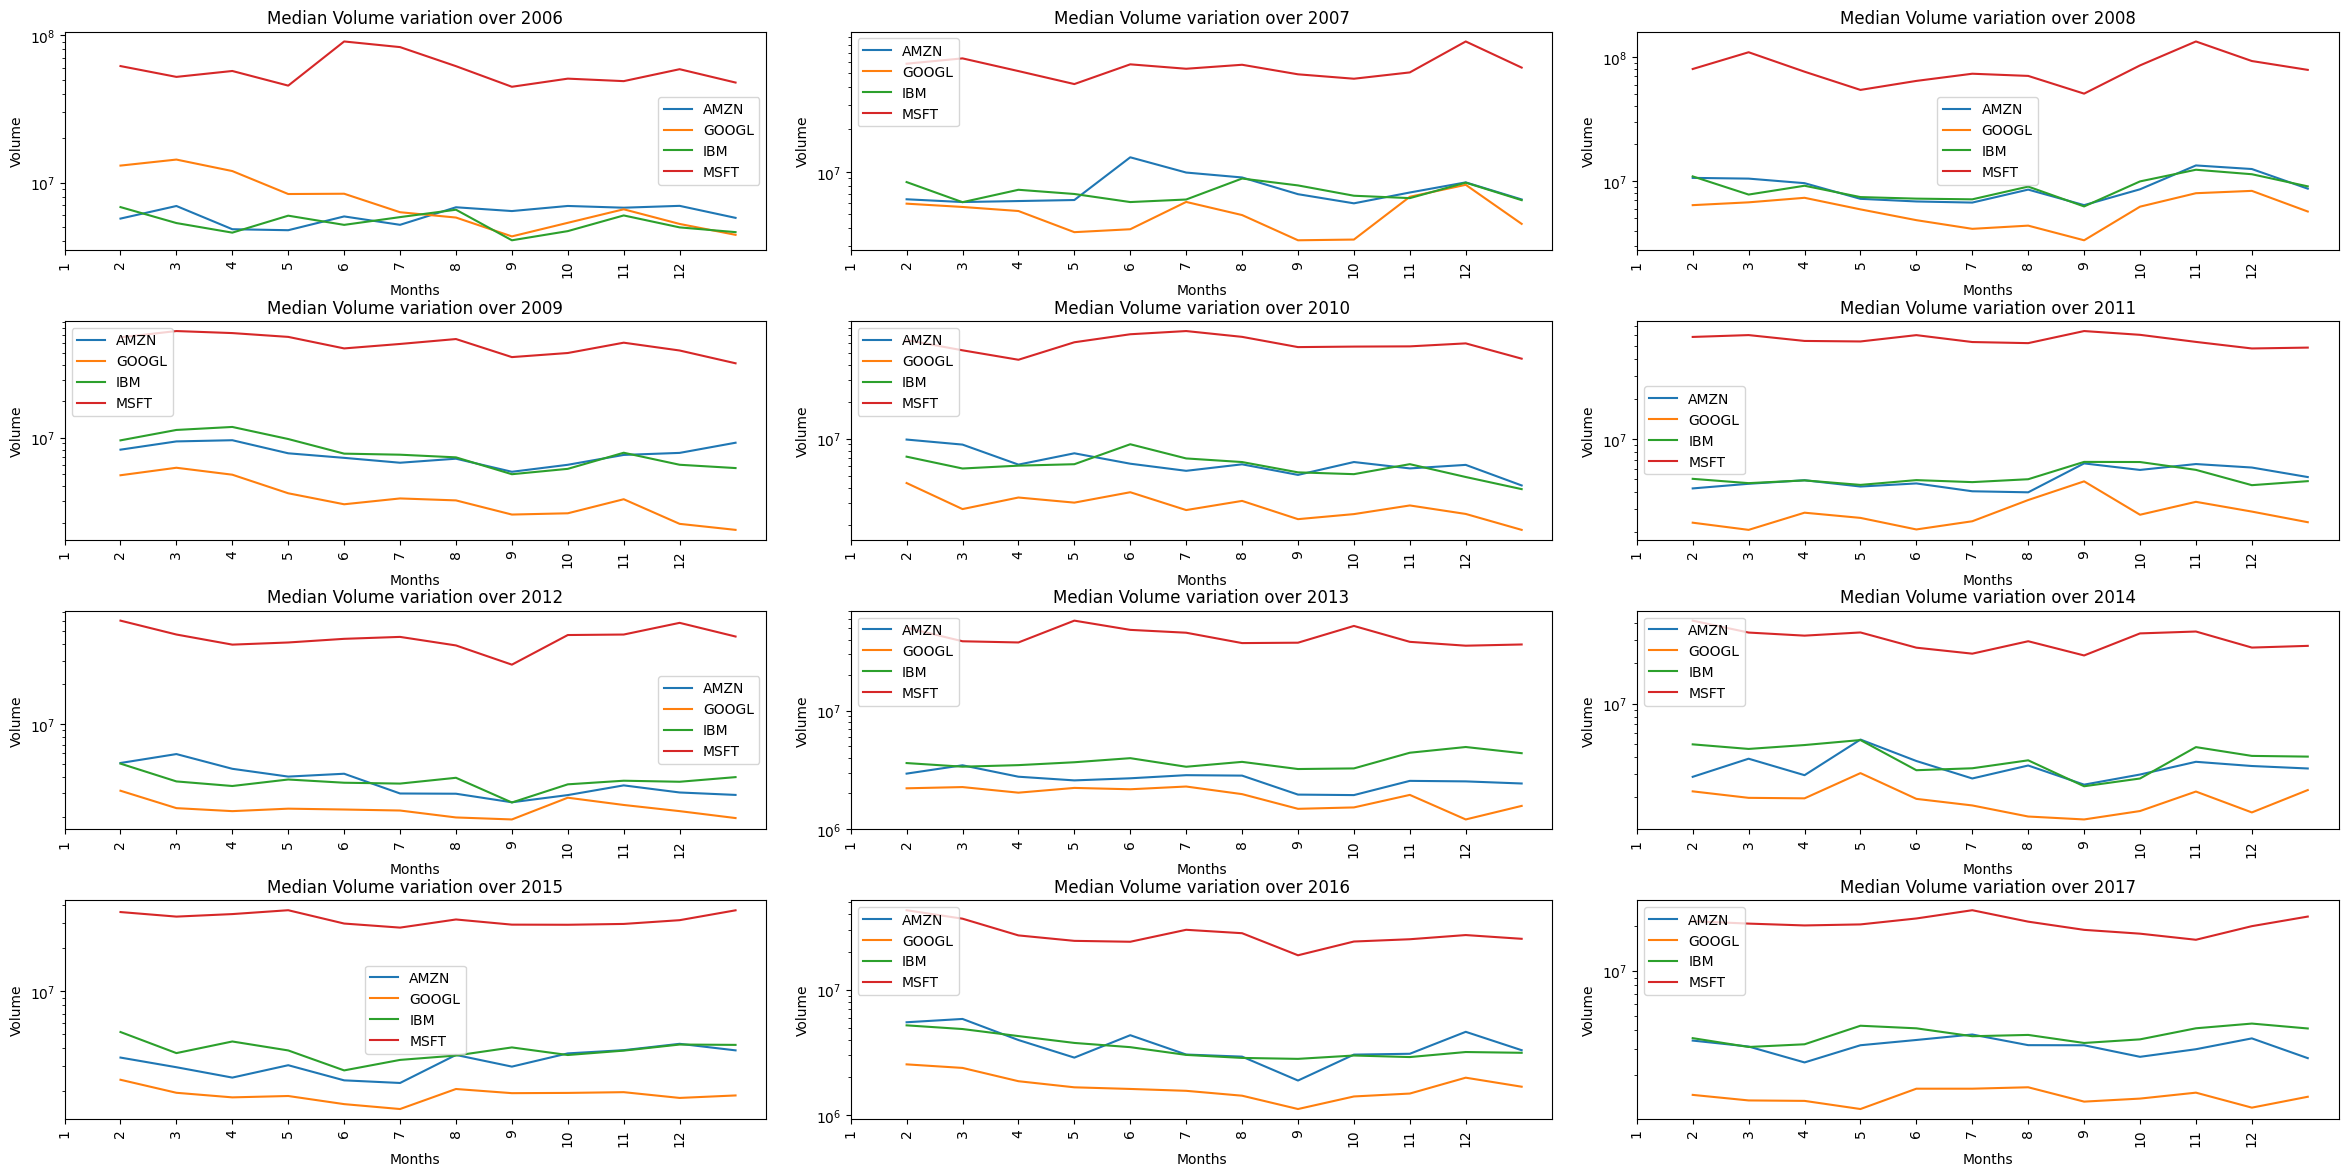

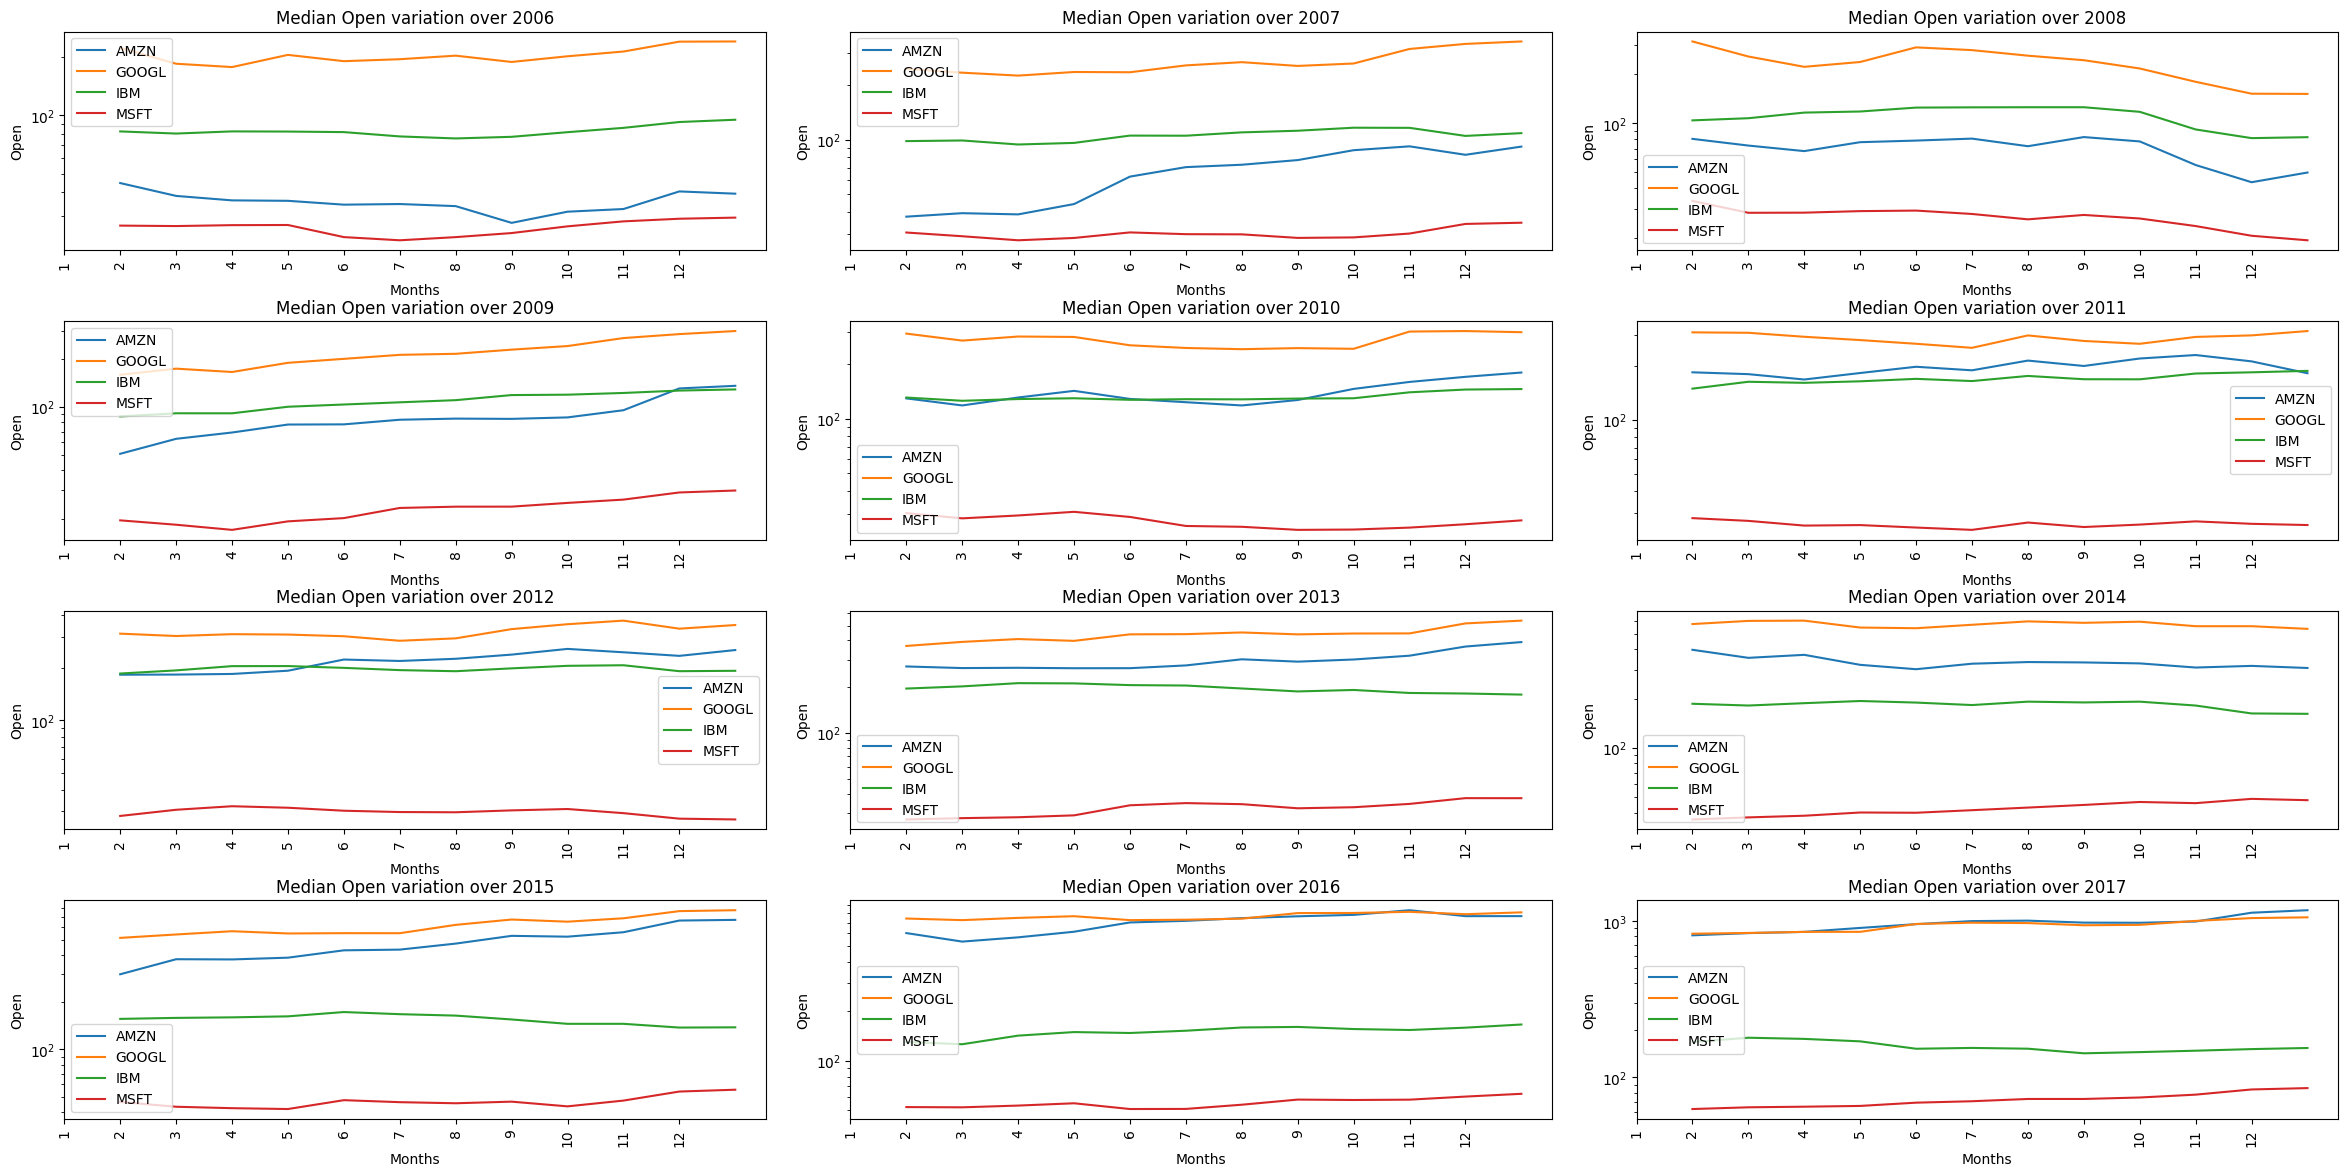

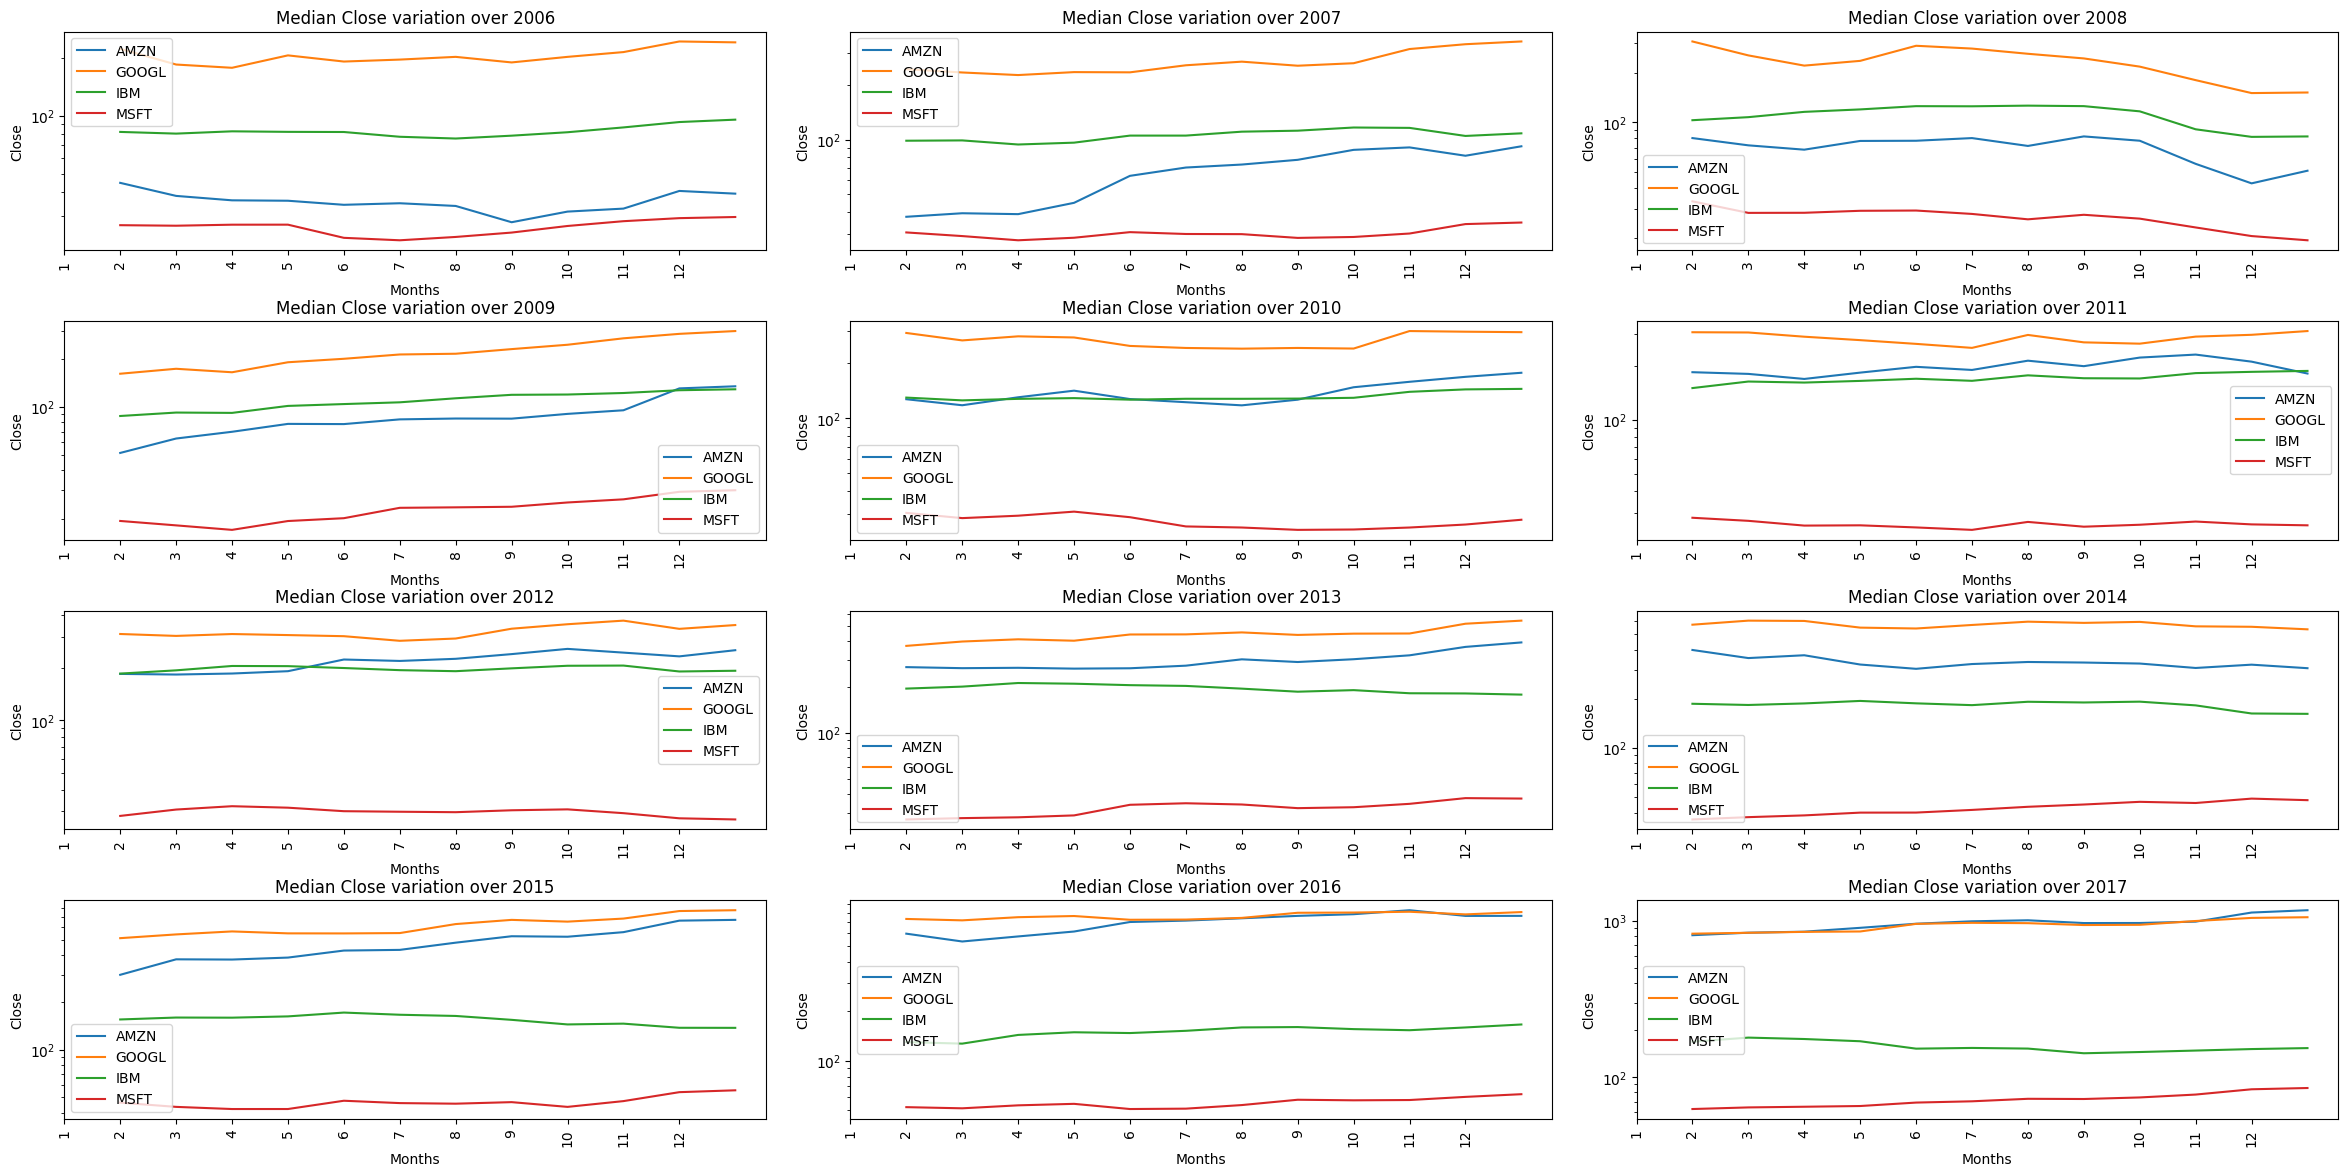

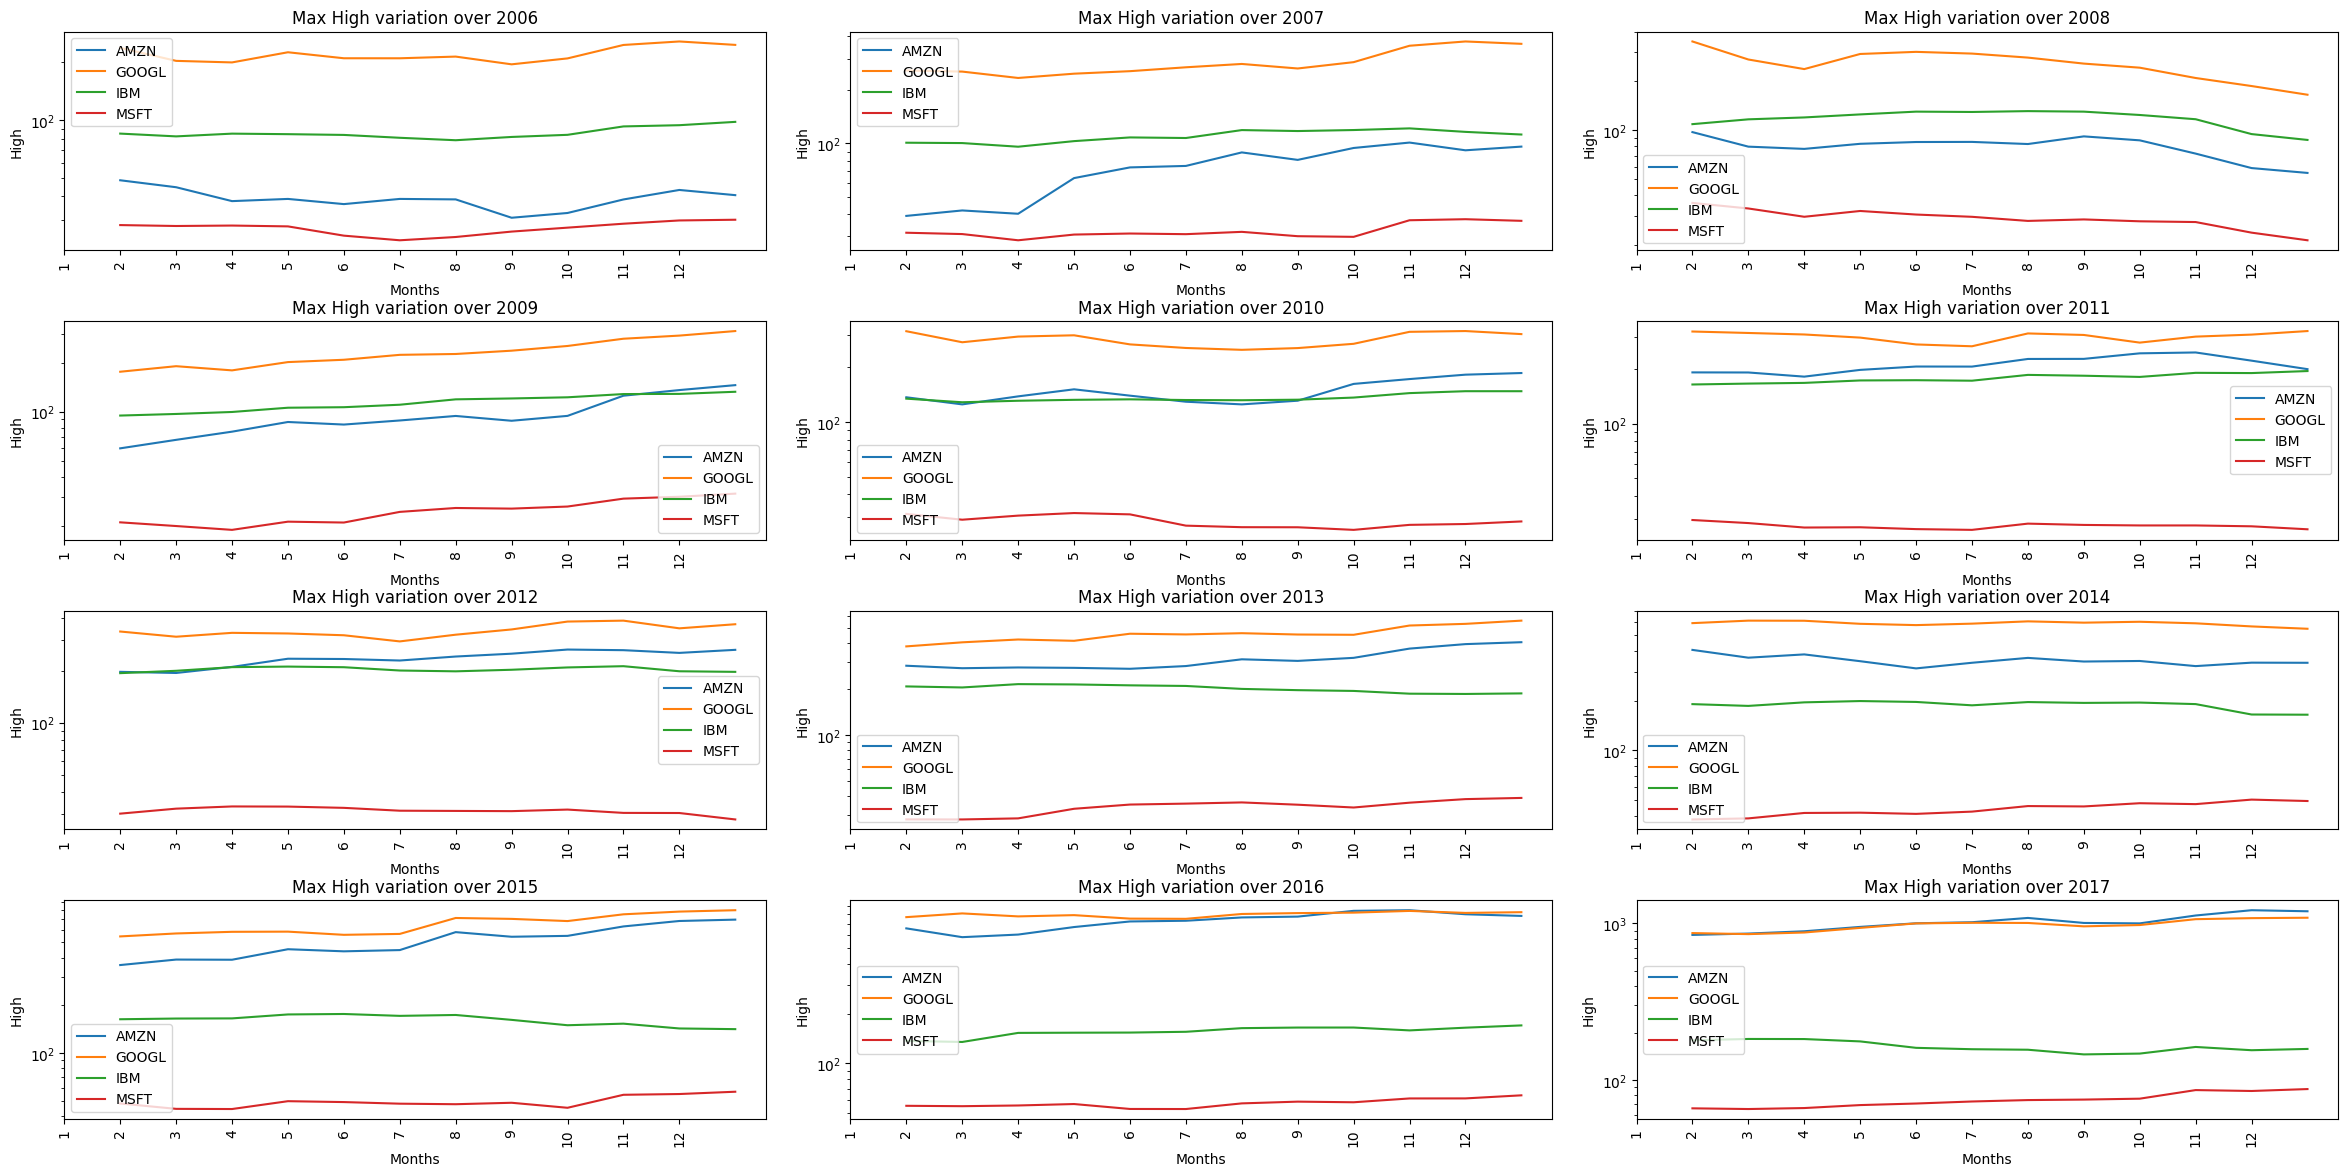

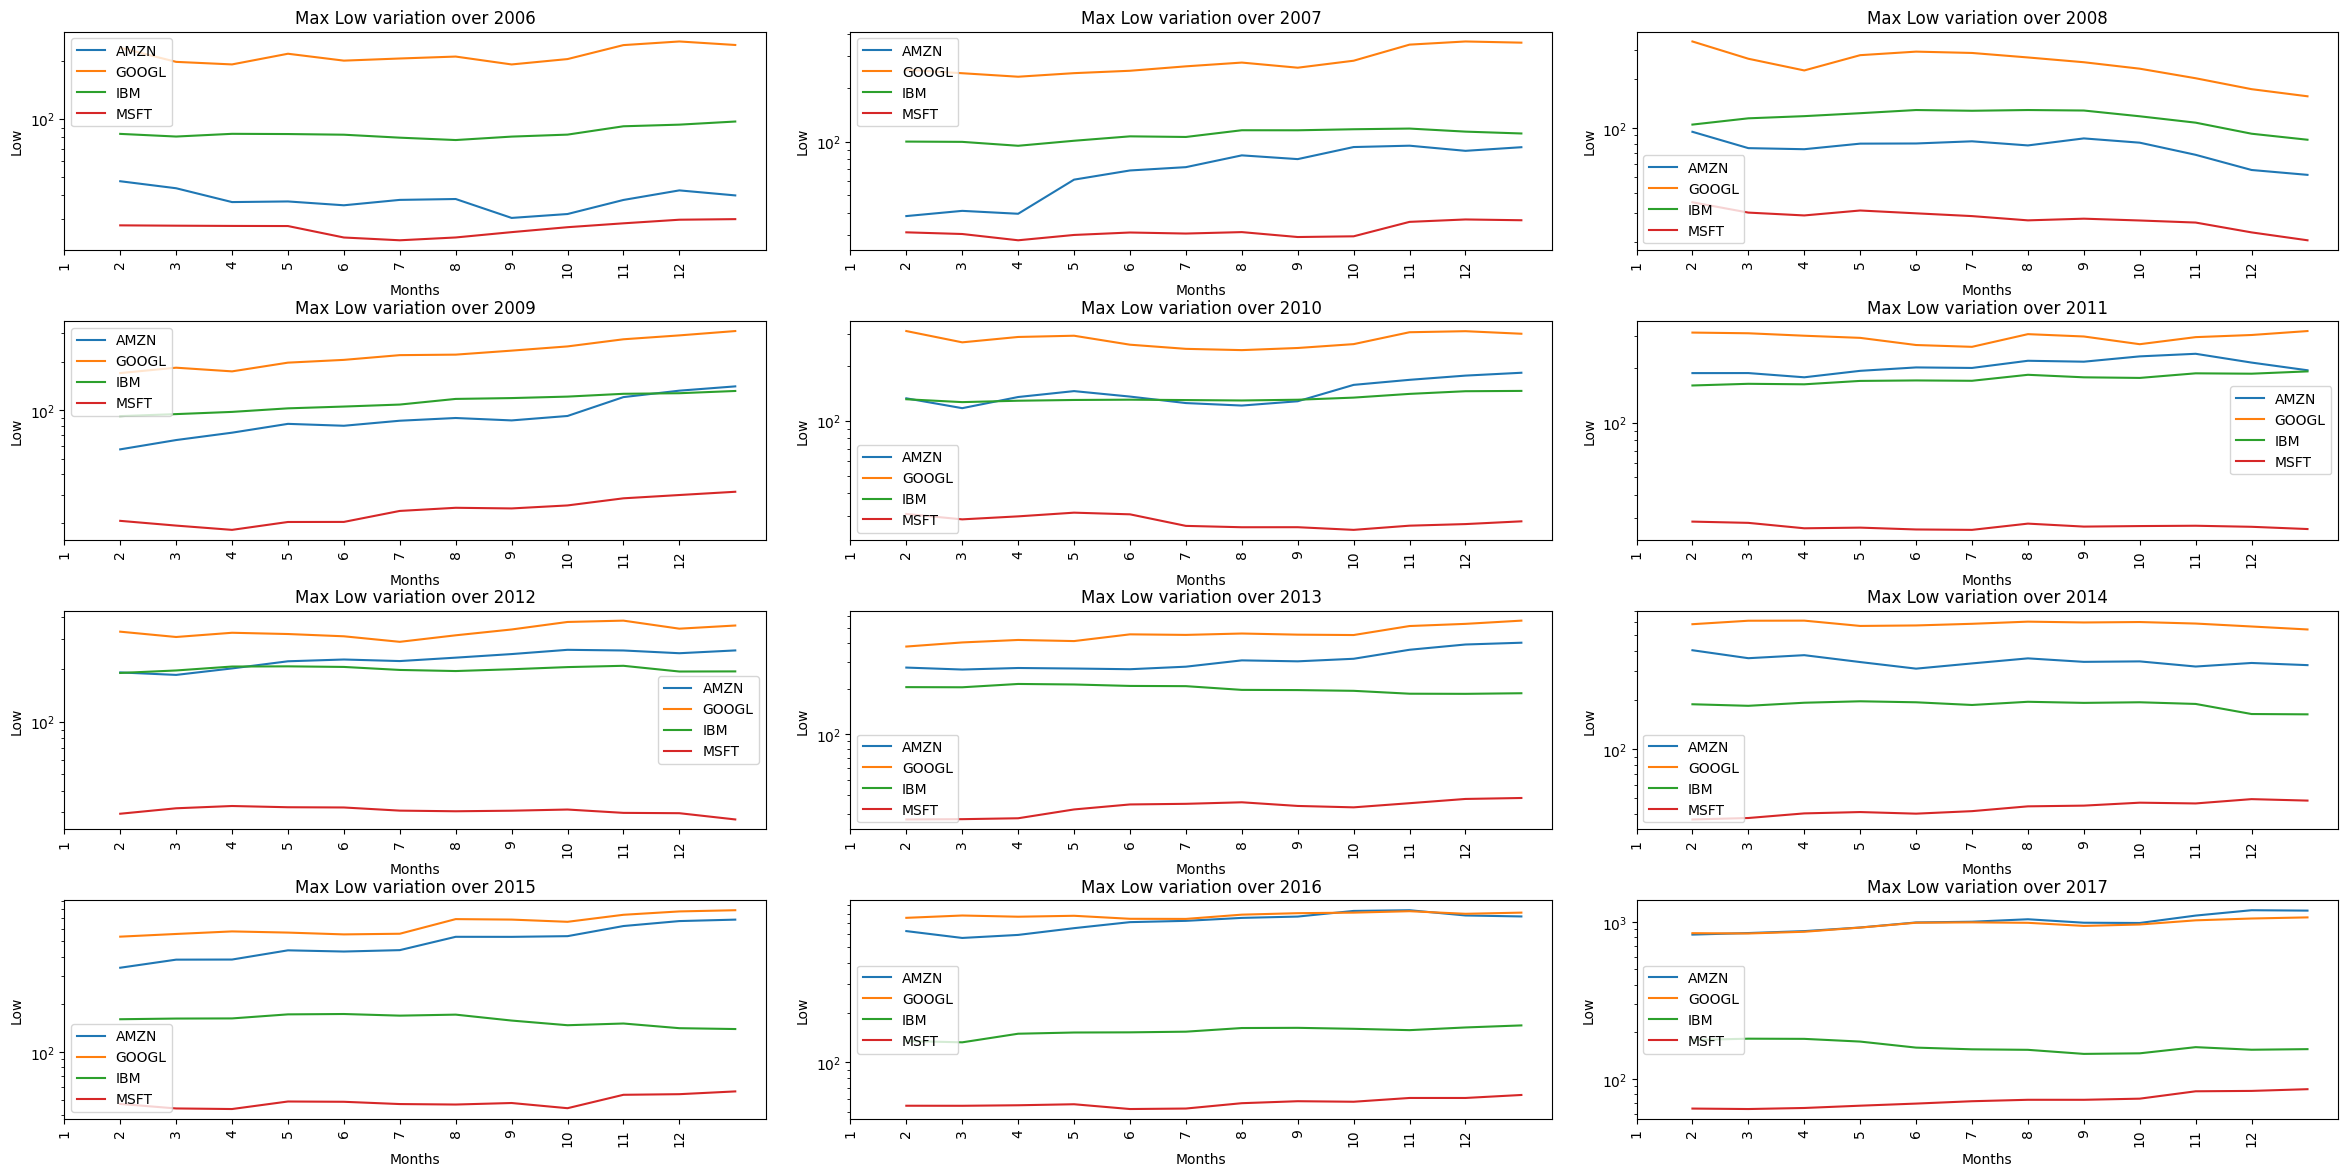

12

In [13]:
# Stock volume variation over time

def plot_over_time(data=None,attribute=None,agg_method='mean',remove_comp=None):

  data_sorted=data.sort_values(["Name","Date"],ascending=True)
  data_sorted['year']=pd.to_datetime(data_sorted['Date']).dt.year
  data_sorted['month']=pd.to_datetime(data_sorted['Date']).dt.month
  data_sorted['day']=pd.to_datetime(data_sorted['Date']).dt.day



  ## Year and company counts
  year_list=data_sorted['year'].unique()
  if remove_comp==None:
    comp_list=data_sorted['Name'].unique()
  else:
    comp_list = list(data_sorted['Name'].unique())
    for remove in remove_comp:
      comp_list.remove(remove)


  fig,axs=plt.subplots(int(len(year_list)/3),int(len(year_list)/4),figsize=(24,12))#,sharey=True)
  fig.tight_layout(pad=3.0)

  for yr,ax in zip(year_list,axs.ravel()):
    subdata=data_sorted.query(f'year=={yr}')
    for comp in comp_list:
      data_group_comp=subdata.query(f'Name=="{comp}"').groupby(['month'])[attribute].agg(agg_method).reset_index()
      data_group_comp = data_group_comp.rename(columns={attribute: f"{attribute}_{agg_method}"})

      ax.plot(data_group_comp['month'],data_group_comp[f'{attribute}_{agg_method}'],label=comp)
      ax.set_xlabel('Months')
      ax.set_xticks(data_group_comp.index,data_group_comp['month'],rotation=90)
      ax.set_ylabel(f'{attribute}')
      ax.grid()
      ax.set_yscale('log')
      ax.set_title(f'{agg_method.capitalize()} {attribute} variation over {yr}')
      ax.legend()
      # print("\n")
  plt.show()
  return len(data_sorted['year'].unique())

plot_over_time(df_stocks_all,attribute="Volume",agg_method='median')#,remove_comp=["GOOGL","AMZN","IBM"])
plot_over_time(df_stocks_all,attribute="Open",agg_method='median')
plot_over_time(df_stocks_all,attribute="Close",agg_method='median')
plot_over_time(df_stocks_all,attribute="High",agg_method='max')
plot_over_time(df_stocks_all,attribute="Low",agg_method='max')



Graphs-Interpretations:
 - Microsoft is traded in high volumes in comparison with other companies. The Open and close price of Microsoft is 10-15 times less than google and Amazon. Affordabilty has a direct proportionality towards increase in volume

 - Google and Amazon has high variance in price within a day.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

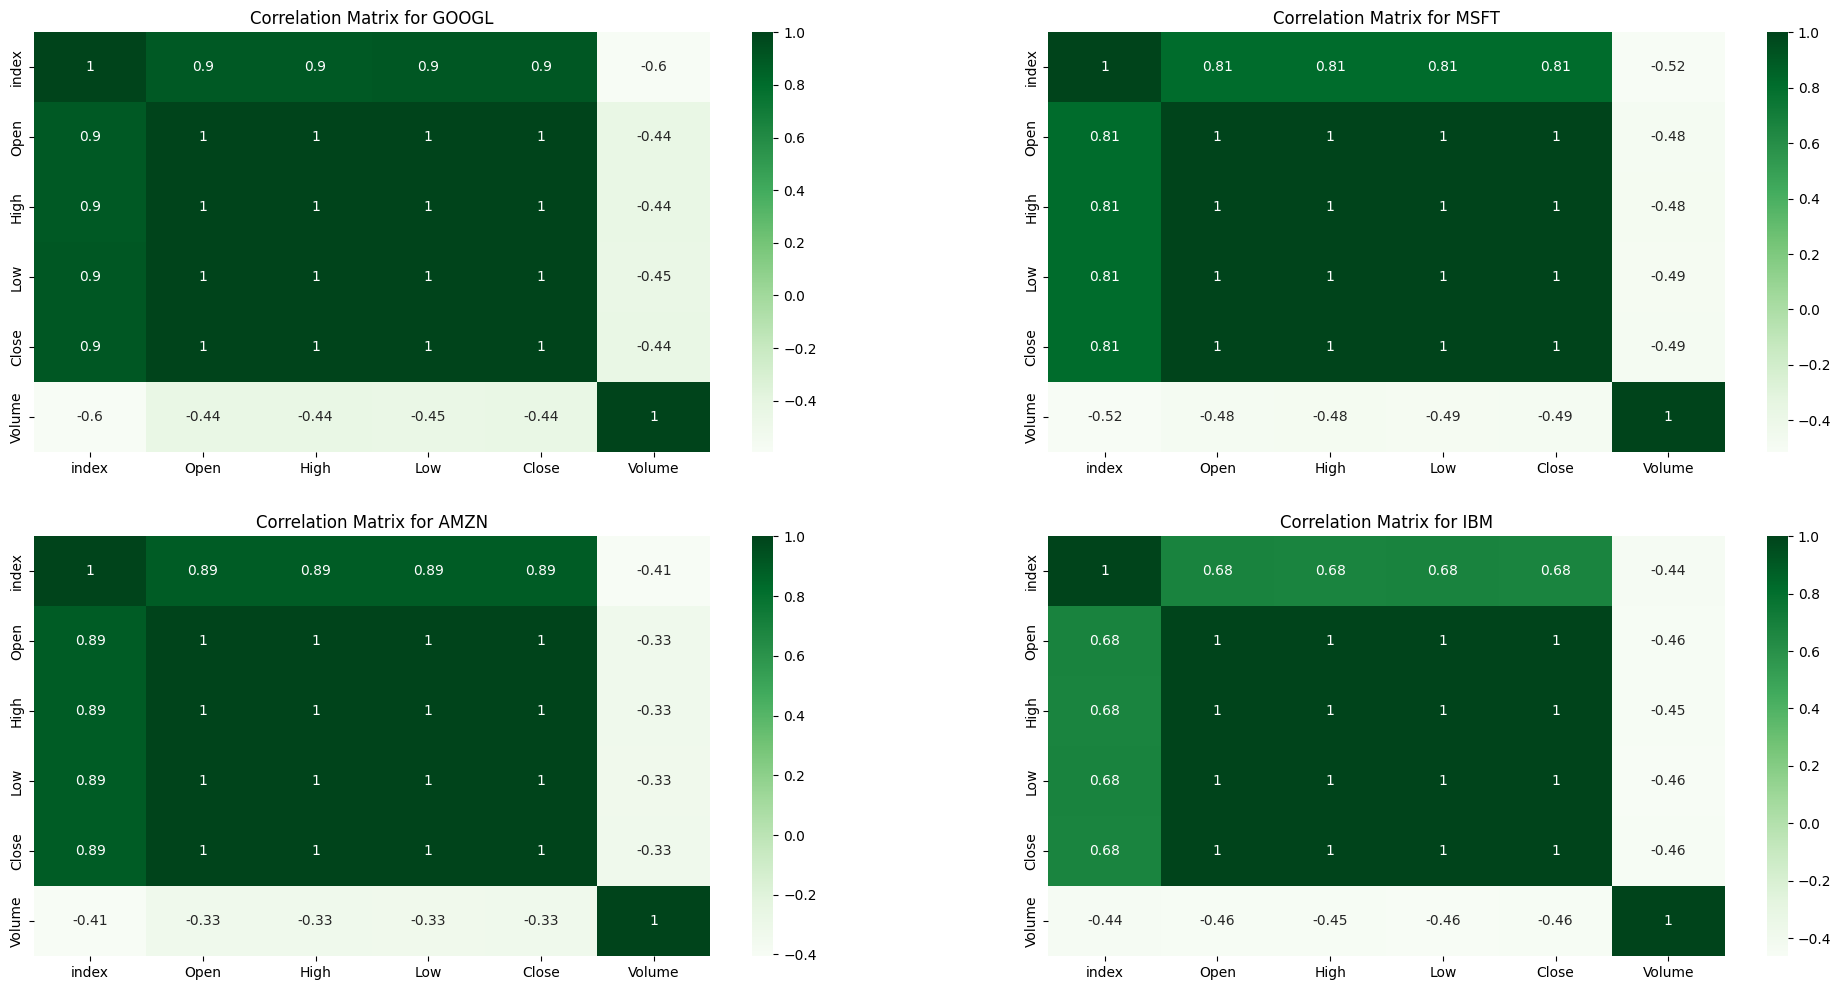

In [14]:
# Analyse correlations
company_list=df_stocks_all['Name'].unique()
comp_corr=pd.DataFrame()
fig,ax=plt.subplots(2,2,figsize=(24,12))

axs=ax.ravel()
for comp,axes in zip(company_list,axs):
  corr_df=df_stocks_all.query(f'Name=="{comp}"').drop(columns=["Date","Name"]).corr()
  comp_corr=pd.concat([comp_corr,corr_df])
  ### plot the correlation ###
  sns.heatmap(corr_df,annot=True,ax=axes,cmap="Greens")
  axes.set_title(f"Correlation Matrix for {comp}")
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [29]:
# Define a function that divides the data into windows and generates target variable values for each window

def windowing_function(n_inputs=None, n_output=None, data=None, attribute=None):
    inputs, targets = [], []
    for i in range(data.shape[0] - (n_inputs + n_output) + 1):
        arr = data[i:i+n_inputs+n_output].values
        X = arr[:n_inputs]
        Y = arr[n_inputs:]  # If multiple outputs
        inputs.append(X.reshape(n_inputs, 1))
        targets.append(Y.reshape(n_output,))
    return np.array(inputs), np.array(targets)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [30]:
def scale_data(train_df=None,test_df=None):

    scaler_train=MinMaxScaler(feature_range=(0,1))

    train=np.array(train_df.values).reshape(-1,1)
    test=np.array(test_df.values).reshape(-1,1)

    scaler_train.fit(train)
    train_scaled=pd.Series(scaler_train.transform(train).flatten())

    test_scaled=pd.Series(scaler_train.transform(test).flatten())



    return train_scaled, test_scaled,scaler_train

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [31]:
# Define a function to create input and output data points from the master DataFrame

def train_test_define(data=None,company_name=None,split_ratio=0.8):
  train_df=pd.DataFrame()
  test_df=pd.DataFrame()
  subdata=data.query(f'Name=="{company_name}"').sort_values('Date',ascending=True).reset_index()
  split_num=int(subdata.shape[0]*0.8)
  train_df=subdata.iloc[:split_num]
  test_df=subdata.iloc[split_num:]
  return train_df,test_df

### Wrapping all the functions in one

def data_preprocessing(data=None,split_ratio=None,n_inputs=None,n_outputs=None,company_name=None,attribute=None):
  ### train test split ###
  train_df,test_df=train_test_define(data=data,company_name=company_name,split_ratio=split_ratio)
  print(f"train_df:{train_df.shape}\ntest_df:{test_df.shape}")


  ### Scale the data ###
  train_scaled, test_scaled,scaler_train=scale_data(train_df=train_df[attribute],test_df=test_df[attribute])
  print(f"train_scaled:{train_scaled.shape}\ntest_scaled:{test_scaled.shape}")


  ###  window function ###
  X_train,Y_train=windowing_function(n_inputs=n_inputs,n_output=n_outputs,data=train_scaled,attribute=attribute)
  print(f"X_train:{X_train.shape}\ny_train:{Y_train.shape}")

  X_test,Y_test=windowing_function(n_inputs=n_inputs,n_output=n_outputs,data=test_scaled,attribute=attribute)
  print(f"X_test:{X_test.shape}\ny_test:{Y_test.shape}")


  return X_train,Y_train,X_test,Y_test,scaler_train

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

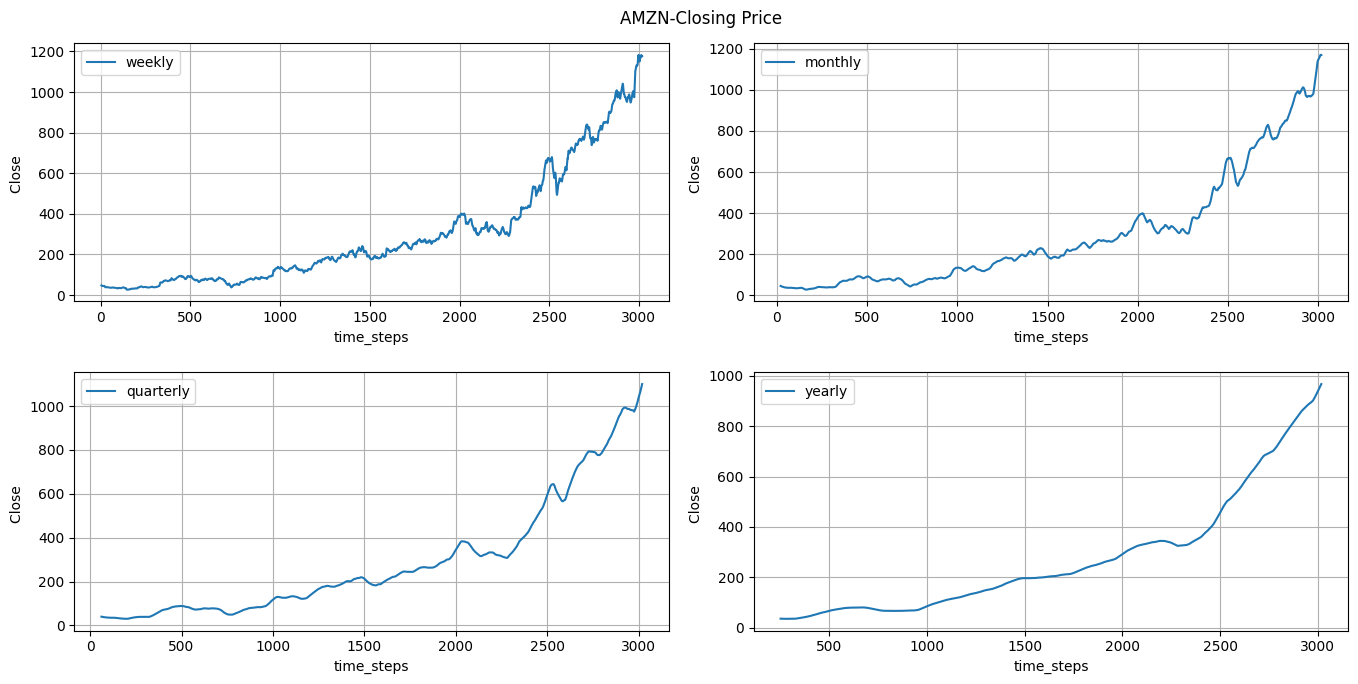

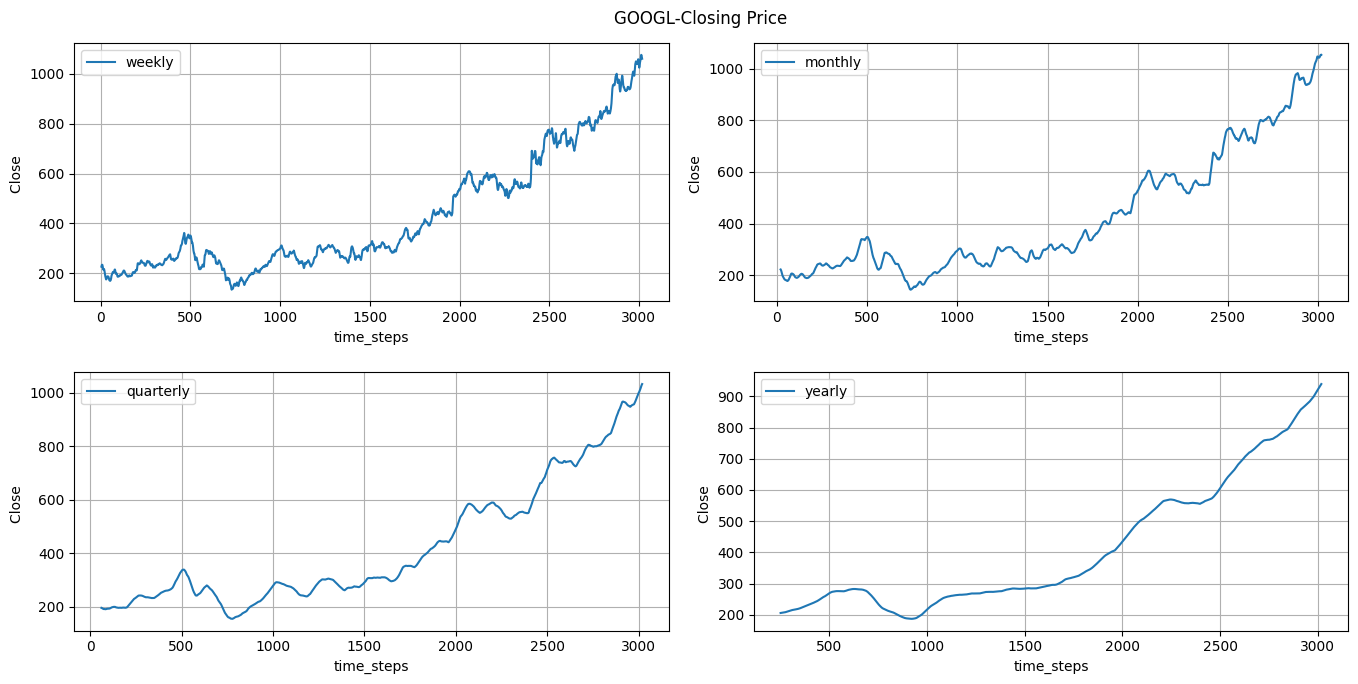

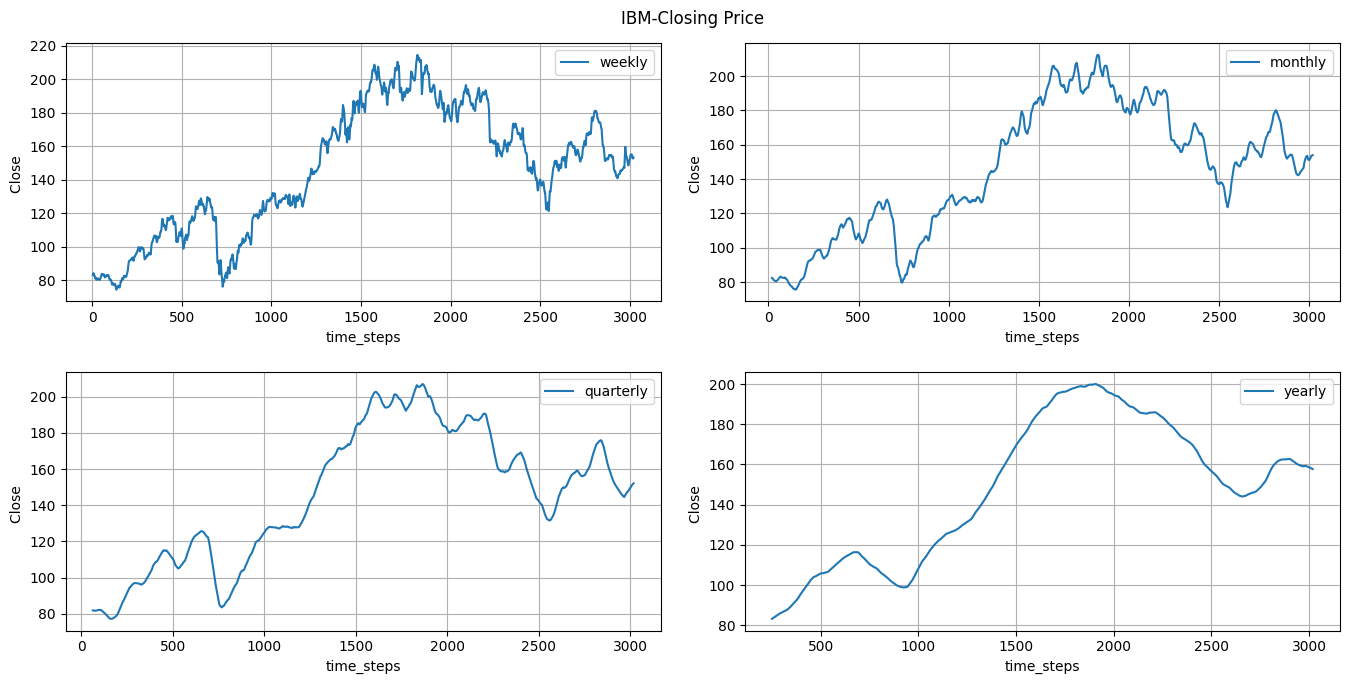

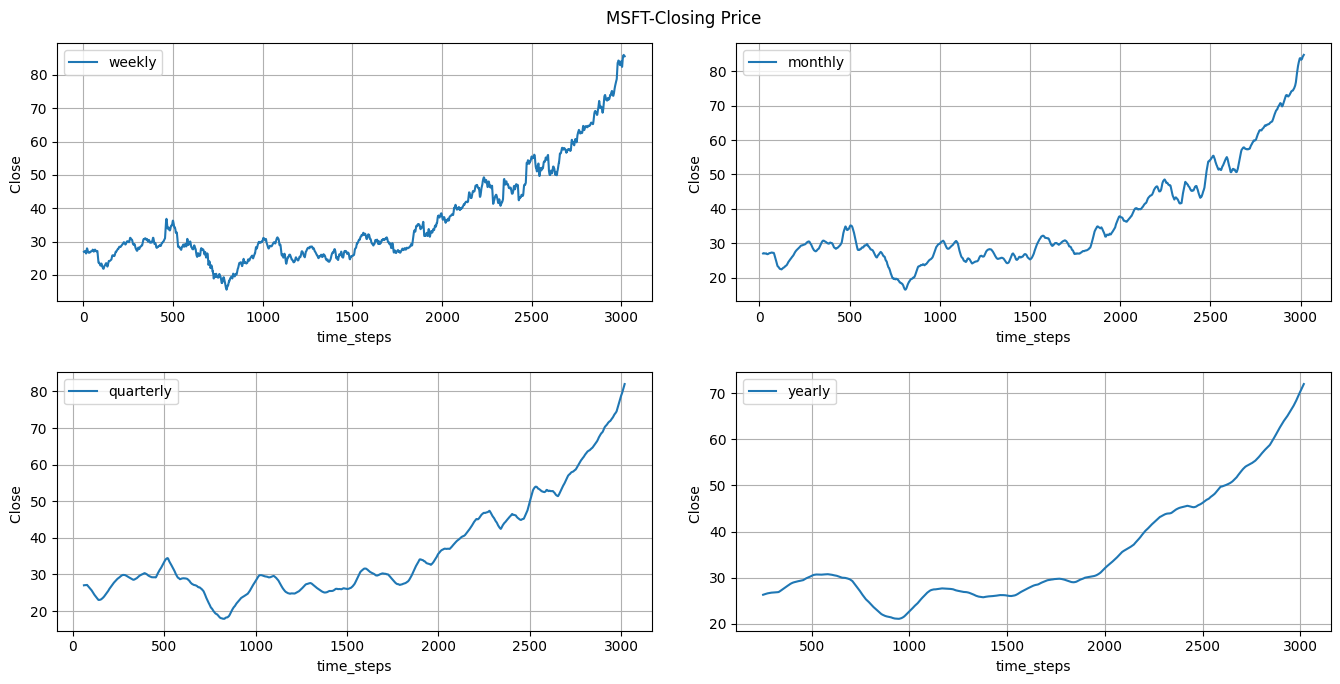

In [32]:
# Checking for patterns in different sequence lengths

## Number of trading days
## Days, months, quarters and yearly trading days
window_size=[5,21,63,252]
window_name=["weekly","monthly","quarterly","yearly"]
def plot_window_pattern(data=None,window_size=list, company_name=None,attribute=None):
  subdata=data.query(f'Name=="{company_name}"').sort_values('Date',ascending=True)
  #### Figure plots ####
  fig,axs=plt.subplots(2,2,figsize=(14,7))
  fig.tight_layout(pad=3.0)
  fig.suptitle(f"{company_name}-Closing Price")
  for window,ax,lbl in zip(window_size,axs.ravel(),window_name):
    x=subdata[attribute].rolling(window=window).mean()
    ax.plot(range(0,len(x)),x,label= f"{lbl}")
    ax.set_xlabel('time_steps')
    ax.set_ylabel(f'{attribute} ')
    ax.legend()
    ax.grid()

    # result = seasonal_decompose(subdata[attribute], model='multiplicative', period=window)
    # result.plot()

  plt.show()
  print("\n")

### Plotting the graphs for different companies ###
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="AMZN",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="GOOGL",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="IBM",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="MSFT",attribute="Close")



Comparing all the companies, window size of 63 has much less noise with reasonable number of patterns captured. So, Quarterly basis input is going into the model

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [33]:
# Create data instances from the master data frame using decided window size and window stride
## Final window size
window_size=4
###
print("\n AMZN")
X_scl_train_amzn,y_scl_train_amzn,X_scl_test_amzn,y_scl_test_amzn,amzn_scalar_x=data_preprocessing(data=df_stocks_all,n_inputs=window_size,n_outputs=1,company_name="AMZN",attribute="Close",split_ratio=0.8)
print("\n GOOGL")
X_scl_train_googl,y_scl_train_googl,X_scl_test_googl,y_scl_test_googl,googl_scalar_x=data_preprocessing(data=df_stocks_all,n_inputs=window_size,n_outputs=1,company_name="GOOGL",attribute="Close",split_ratio=0.8)
print("\n MSFT")
X_scl_train_mfst,y_scl_train_mfst,X_scl_test_mfst,y_scl_test_mfst,mfst_scalar_x=data_preprocessing(data=df_stocks_all,n_inputs=window_size,n_outputs=1,company_name="MSFT",attribute="Close",split_ratio=0.8)
print("\n IBM")
X_scl_train_ibm,y_scl_train_ibm,X_scl_test_ibm,y_scl_test_ibm,ibm_scalar_x=data_preprocessing(data=df_stocks_all,n_inputs=window_size,n_outputs=1,company_name="IBM",attribute="Close",split_ratio=0.8)




 AMZN
train_df:(2415, 9)
test_df:(604, 9)
train_scaled:(2415,)
test_scaled:(604,)
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

 GOOGL
train_df:(2415, 9)
test_df:(604, 9)
train_scaled:(2415,)
test_scaled:(604,)
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

 MSFT
train_df:(2415, 9)
test_df:(604, 9)
train_scaled:(2415,)
test_scaled:(604,)
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

 IBM
train_df:(2416, 9)
test_df:(604, 9)
train_scaled:(2416,)
test_scaled:(604,)
X_train:(2412, 4, 1)
y_train:(2412, 1)
X_test:(600, 4, 1)
y_test:(600, 1)


In [34]:
# np.concat([X_train_amzn,Y_test_amzn]).shape, X_train_amzn.shape

In [35]:
# Check the number of data points generated
print("\nAmazon")
X_train_amzn,Y_train_amzn=np.array(X_scl_train_amzn),np.array(y_scl_train_amzn)
X_test_amzn,Y_test_amzn=np.array(X_scl_test_amzn),np.array(y_scl_test_amzn)
## list 5 observations
print(f"X_train:{X_train_amzn[:1]}\ny_train:{Y_train_amzn[:1]}")
print(f"X_test:{X_test_amzn[:1]}\ny_test:{Y_test_amzn[:1]}")

print("\nGoogle")
X_train_googl,Y_train_googl=np.array(X_scl_train_googl),np.array(y_scl_train_googl)
X_test_googl,Y_test_googl=np.array(X_scl_test_googl),np.array(y_scl_test_googl)
## list 5 observation
print(f"X_train:{X_train_googl[:1]}\ny_train:{Y_train_googl[:1]}")
print(f"X_test:{X_test_googl[:1]}\ny_test:{Y_test_googl[:1]}")

print("\nMicrosoft")
X_train_msft,Y_train_msft=np.array(X_scl_train_mfst),np.array(y_scl_train_mfst)
X_test_msft,Y_test_msft=np.array(X_scl_test_mfst),np.array(y_scl_test_mfst)
## list 5 observation
print(f"X_train:{X_train_msft[:1]}\ny_train:{Y_train_msft[:1]}")
print(f"X_test:{X_test_msft[:1]}\ny_test:{Y_test_msft[:1]}")

print("\nIBM")
X_train_ibm,Y_train_ibm=np.array(X_scl_train_ibm),np.array(y_scl_train_ibm)
X_test_ibm,Y_test_ibm=np.array(X_scl_test_ibm),np.array(y_scl_test_ibm)
## list 5 observation
print(f"X_train:{X_train_ibm[:1]}\ny_train:{Y_train_ibm[:1]}")
print(f"X_test:{X_test_ibm[:1]}\ny_test:{Y_test_ibm[:1]}")



Amazon
X_train:[[[0.04209888]
  [0.04145301]
  [0.04223588]
  [0.04266646]]]
y_train:[[0.04112029]]
X_test:[[[0.97453713]
  [0.98130896]
  [0.97827534]
  [0.98561475]]]
y_test:[[0.9892551]]

Google
X_train:[[[0.15589467]
  [0.16467228]
  [0.16994586]
  [0.18257792]]]
y_train:[[0.18366417]]
X_test:[[[0.93608634]
  [0.98367118]
  [0.98572104]
  [0.97703103]]]
y_test:[[0.9820418]]

Microsoft
X_train:[[[0.33923389]
  [0.34300638]
  [0.34358677]
  [0.34126524]]]
y_train:[[0.33981428]]
X_test:[[[0.93383633]
  [0.90713871]
  [0.91671503]
  [0.91642484]]]
y_test:[[0.92426001]]

IBM
X_train:[[[0.07163682]
  [0.07087325]
  [0.0746911 ]
  [0.0916979 ]]]
y_train:[[0.08322921]]
X_test:[[[0.59010135]
  [0.58149382]
  [0.58600583]
  [0.57843954]]]
y_test:[[0.58315979]]



**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [36]:
# Check if the datasets are compatible inputs to neural networks

print("\nAmazon")
print(f"X_train:{X_train_amzn.shape}\ny_train:{Y_train_amzn.shape}")
print(f"X_test:{X_test_amzn.shape}\ny_test:{Y_test_amzn.shape}")

print("\nGoogle")
print(f"X_train:{X_train_googl.shape}\ny_train:{Y_train_googl.shape}")
print(f"X_test:{X_test_googl.shape}\ny_test:{Y_test_googl.shape}")

print("\nMicrosoft")
print(f"X_train:{X_train_msft.shape}\ny_train:{Y_train_msft.shape}")
print(f"X_test:{X_test_msft.shape}\ny_test:{Y_test_msft.shape}")

print("\nIBM")
print(f"X_train:{X_train_ibm.shape}\ny_train:{Y_train_ibm.shape}")
print(f"X_test:{X_test_ibm.shape}\ny_test:{Y_test_ibm.shape}")




Amazon
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

Google
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

Microsoft
X_train:(2411, 4, 1)
y_train:(2411, 1)
X_test:(600, 4, 1)
y_test:(600, 1)

IBM
X_train:(2412, 4, 1)
y_train:(2412, 1)
X_test:(600, 4, 1)
y_test:(600, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [54]:
# Create a function that creates a simple RNN model according to the model configuration arguments
### Hyperparametrs
n_units=[32,64,128]
dense_units=[16,32,64]
dropouts=[0.3,0.5]
activation=['relu','tanh']
learning_rate=[5e-4,2e-3,1e-4,10e-3]
opt=['adam','sgd','rmsprop']
### Combinations
configs_list=list(itertools.product(n_units,dense_units,dropouts,activation,learning_rate))
configurations=[]

for config,num in zip(configs_list,range(len(configs_list))):
  configurations.append({'name': f'Config_{num+1}','n_units':config[0],'dense_units':config[1],'dropout':config[2],'activation':config[3],'learning_rate':config[4]})
print(configurations)
print(f"Total number of configurations:{len(configurations)}")

configs_df=pd.DataFrame(configurations)


def create_simple_rnn_model(X=None,configurations=list):
  ### Initializing the model
  model=Sequential()
  ### Add layers of simple RNN - input layer
  model.add(SimpleRNN(units=configurations['n_units'],return_sequences=False,kernel_initializer="glorot_uniform",input_shape=(X.shape[1],X.shape[2])))
  ## HIDDEN LAYER 1
  model.add(Dense(units=configurations['dense_units'], activation=configurations['activation']))
  model.add(Activation(configurations['activation']))
  model.add(Dropout(configurations['dropout']))
  ## Hidden layer -2
  model.add(Dense(units=configurations['dense_units'], activation=configurations['activation']))
  model.add(Activation(configurations['activation']))
  model.add(Dropout(configurations['dropout']))
  ### Output layer
  model.add(Dense(units=1))
  # print(model.summary())

  return model



[{'name': 'Config_1', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'relu', 'learning_rate': 0.0005}, {'name': 'Config_2', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'relu', 'learning_rate': 0.002}, {'name': 'Config_3', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'relu', 'learning_rate': 0.0001}, {'name': 'Config_4', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'relu', 'learning_rate': 0.01}, {'name': 'Config_5', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'tanh', 'learning_rate': 0.0005}, {'name': 'Config_6', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'tanh', 'learning_rate': 0.002}, {'name': 'Config_7', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'tanh', 'learning_rate': 0.0001}, {'name': 'Config_8', 'n_units': 32, 'dense_units': 16, 'dropout': 0.3, 'activation': 'tanh', 'learning_rate': 0.01}, {'name': 'Config_9', 'n_units': 32, 'dense_units': 16

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [38]:
### print only final epoch function ####
class FinalEpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.params['epochs'] - 1:
            print(f"Final Epoch {epoch+1}: {logs}")

In [ ]:
# Find an optimal configuration of simple RNN
epoch=100
batch_size=32
history_list={}
y_preds_dict={}
metrics_dict={}


for config in configurations:
  print( f"Processing {[config]}")
  model_amzn=create_simple_rnn_model(X=X_train_amzn,configurations=config)
  ### compile model
  opt_dict = {
    'adam': Adam(learning_rate=config['learning_rate']),
    'sgd': SGD(learning_rate=config['learning_rate']),
    'rmsprop': RMSprop(learning_rate=config['learning_rate'])
  }
  model_amzn.compile(optimizer=opt_dict['adam'], loss='mean_squared_error',metrics=["mse"])
  ### fit the model
  history_amzn=model_amzn.fit(X_train_amzn,Y_train_amzn,epochs=epoch,batch_size=batch_size,validation_data=(X_test_amzn,Y_test_amzn),verbose=0,callbacks=[FinalEpochLogger()])
  history_list[config['name']]=history_amzn.history

  ### Predict on the test data
  y_pred=model_amzn.predict(X_test_amzn)
  y_preds_dict[config['name']]=y_pred

  ### Metrics dictionary
  y_test=Y_test_amzn.reshape(-1,1)
  mse=mean_squared_error(y_test,y_pred)
  mae=mean_absolute_error(y_test,y_pred)
  r2=r2_score(y_test,y_pred)
  metrics_dict[config['name']]=[mse,mae,r2]
  print(f"MSE:{mse}\nMAE:{mae}\nR2:{r2}")

  print("\n")

In [101]:
# Find the best configuration based on evaluation metrics

#### Getting the best models using validation metrices
metrics_df=pd.DataFrame(metrics_dict).T.rename(columns={0:"MSE",1:"MAE",2:"R2"}).sort_values('R2',ascending=False).reset_index()
display(metrics_df.head())
best_fit=metrics_df.iloc[0]
print(f'best_config:\n')
display(configs_df[configs_df["name"]==best_fit["index"]])



,index,MSE,MAE,R2
0,Config_90,0.000788,0.020112,0.993595
1,Config_81,0.001178,0.025925,0.990426
2,Config_82,0.001299,0.027410,0.989443
3,Config_65,0.001421,0.026300,0.988444
4,Config_137,0.002444,0.043814,0.980134


best_config:



,name,n_units,dense_units,dropout,activation,learning_rate
89,Config_90,64,64,0.5,relu,0.002


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [115]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


best_config_name = best_fit["index"]  # Get the name of the best configuration
best_config = configs_df[configs_df["name"] == best_config_name].to_dict('records')[0]
print("best_config\n",best_config)
best_learning_rate = best_config['learning_rate']  # Extract the learning rate

simple_rnn_best = create_simple_rnn_model(X=X_train_amzn, configurations=best_config)
simple_rnn_best.compile(optimizer=Adam(best_learning_rate), loss='mean_squared_error', metrics=["mse"])  # Compile with the correct learning rate
### fit the model
simple_rnn_best.fit(X_train_amzn, Y_train_amzn, epochs=epoch, batch_size=batch_size, validation_data=(X_test_amzn, Y_test_amzn), verbose=0,callbacks=[FinalEpochLogger()])
## Evalualte the model
train_val=simple_rnn_best.evaluate(X_train_amzn,Y_train_amzn)
test_val=simple_rnn_best.evaluate(X_test_amzn,Y_test_amzn)
print(f"Train Loss:{train_val}\nTest Loss:{test_val}")

### Predict on the test data
y_pred_test = simple_rnn_best.predict(X_test_amzn)
y_pred_train = simple_rnn_best.predict(X_train_amzn)

### Print train and test
print(f"Rsquared-score for test:{100*r2_score(Y_test_amzn,y_pred_test):.2f}%")
print(f"Rsquared-score for train:{100*r2_score(Y_train_amzn,y_pred_train):.2f}%")

y_pred_test_inv=amzn_scalar_x.inverse_transform(y_pred_test)
y_test_inv=amzn_scalar_x.inverse_transform(Y_test_amzn)




best_config
 {'name': 'Config_90', 'n_units': 64, 'dense_units': 64, 'dropout': 0.5, 'activation': 'relu', 'learning_rate': 0.002}
Final Epoch 100: {'loss': 0.002790393540635705, 'mse': 0.002790393540635705, 'val_loss': 0.003786675864830613, 'val_mse': 0.003786675864830613}
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mse: 0.0027
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mse: 0.0021         
Train Loss:[0.0013784720795229077, 0.0013784720795229077]
Test Loss:[0.003786675864830613, 0.003786675864830613]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Rsquared-score for test:96.92%
Rsquared-score for train:97.39%


Plotting the actual vs predicted values

Text(0.5, 1.0, 'AMZN-Closing price predictions vs actuals')

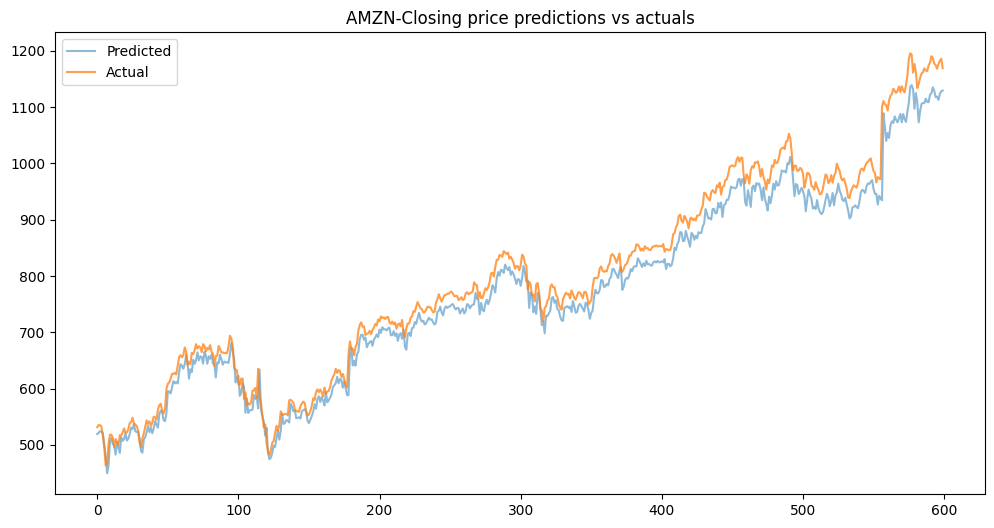

In [116]:
## Plot Actual VS Predictions

plt.figure(figsize=(12,6))
plt.plot(y_pred_test_inv ,label="Predicted",alpha=0.5)
plt.plot(y_test_inv,label="Actual",alpha=0.75)
plt.legend()
plt.title(f"AMZN-Closing price predictions vs actuals")


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

best_config
 {'name': 'Config_90', 'n_units': 64, 'dense_units': 64, 'dropout': 0.5, 'activation': 'relu', 'learning_rate': 0.002}
Final Epoch 100: {'loss': 0.01750723086297512, 'mse': 0.01750723086297512, 'val_loss': 0.0022492101415991783, 'val_mse': 0.0022492101415991783}
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mse: 0.0011         
Train Loss:[0.0013784720795229077, 0.0013784720795229077]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rsquared-score for test:98.90%


Text(0.5, 1.0, 'AMZN-Closing price predictions vs actuals - Trained and predicted on Test data')

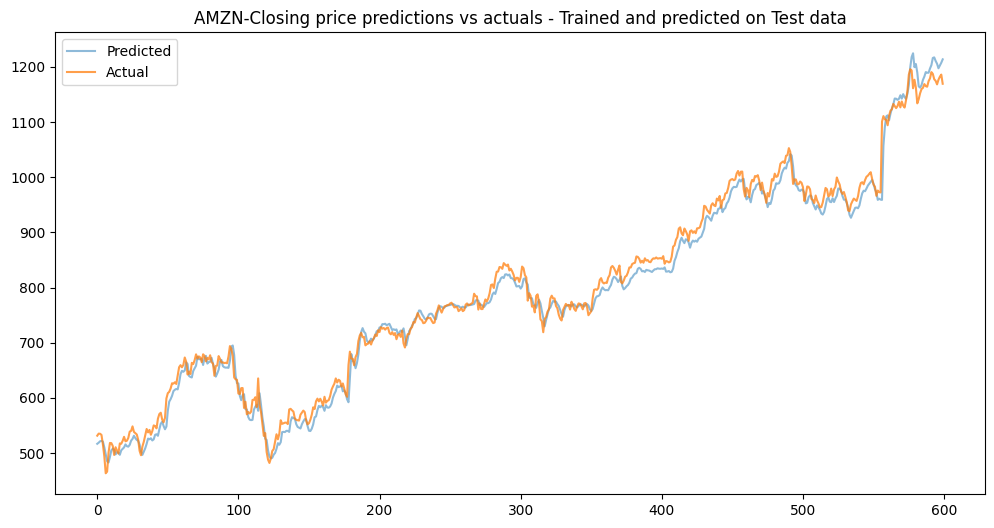

In [117]:
# Compute the performance of the model on the testing data set
best_config_name = best_fit["index"]  # Get the name of the best configuration
best_config = configs_df[configs_df["name"] == best_config_name].to_dict('records')[0]
print("best_config\n",best_config)
best_learning_rate = best_config['learning_rate']  # Extract the learning rate

simple_rnn_best = create_simple_rnn_model(X=X_test_amzn, configurations=best_config)
simple_rnn_best.compile(optimizer=Adam(best_learning_rate), loss='mean_squared_error', metrics=["mse"])  # Compile with the correct learning rate
### fit the model
simple_rnn_best.fit(X_test_amzn, Y_test_amzn, epochs=epoch, batch_size=batch_size, validation_split=0.2, verbose=0,callbacks=[FinalEpochLogger()])
## Evalualte the model
test_val=simple_rnn_best.evaluate(X_test_amzn,Y_test_amzn)
print(f"Train Loss:{train_val}")

### Predict on the test data
y_pred_test = simple_rnn_best.predict(X_test_amzn)

### Print train and test
print(f"Rsquared-score for test:{100*r2_score(Y_test_amzn,y_pred_test):.2f}%")

y_pred_test_inv=amzn_scalar_x.inverse_transform(y_pred_test)
y_test_inv=amzn_scalar_x.inverse_transform(Y_test_amzn)

## Plot Actual VS Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_pred_test_inv, label="Predicted", alpha=0.5)
plt.plot(y_test_inv, label="Actual", alpha=0.75)
plt.legend()
plt.title(f"AMZN-Closing price predictions vs actuals - Trained and predicted on Test data")


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.